# Libraries

In [1]:
import os
import json
from io import BytesIO
import requests
from shapely.geometry import Point

import pandas as pd
import geopandas as gpd
import osmnx as ox

## Data

### Citrix Cycle Docks

I'm going to download a copy of this data, but also I want to write it as a function for a live demo.

In [2]:
def cc_docks_example_gdf():
    cc_docks_r = requests.get('https://citrixcycle.com/stations/stations/')
    cc_docks_df = pd.read_json(BytesIO(cc_docks_r.content))
    cc_docks_reduced_df = cc_docks_df.loc[:,['id', 'locking_station_type', 'description', 'address', 'primary_locked_cycle_count', 'stocking_low', 'total_locked_cycle_count', 'free_spaces', 'location']]
    cc_docks_reduced_df['geometry'] = cc_docks_reduced_df.apply(lambda x: Point(x['location'][1],x['location'][0]), axis = 1)
    cc_docks_reduced_df.drop(columns=['location'], inplace = True)
    return gpd.GeoDataFrame(cc_docks_reduced_df, geometry = 'geometry', crs={'init': 'epsg:4326'})


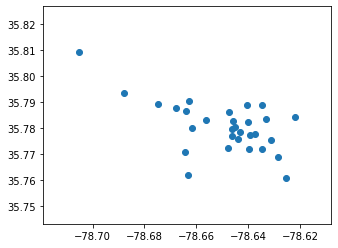

In [3]:
cc_docks_example_gdf().plot()

In [4]:
import pyproj
pyproj.Proj("+init=epsg:4326")

pyproj.Proj('+units=m +init=epsg:4326', preserve_units=True)

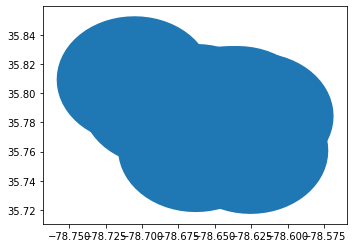

In [31]:
cc_docks_buffer = cc_docks_example_gdf()
cc_docks_buffer.to_crs(epsg=2264, inplace = True)
cc_docks_buffer = gpd.GeoDataFrame([row.geometry.buffer(3 * 5280) for index, row in cc_docks_buffer.iterrows()], columns = ['geometry'], geometry = 'geometry', crs = {'init':'epsg:2264'})
cc_docks_buffer = cc_docks_buffer.to_crs({'init':'epsg:4326'})
cc_docks_buffer.plot()
cc_docks_buffer.to_file('./DATA/test_buffer.geojson', driver = 'GeoJSON')

In [129]:
cc_docks_example_gdf().to_file('./DATA/cc_docks_20191108_1319.geojson', driver = 'GeoJSON')

AttributeError: 'NoneType' object has no attribute 'nodes'

### Bike network

AttributeError: No geometry data set yet (expected in column 'geometry'.

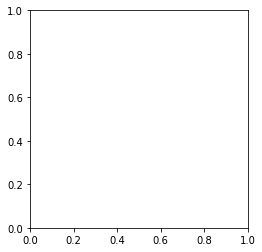

In [134]:
gpd.GeoDataFrame(cc_docks_example_gdf().total_bounds)

In [132]:
north = cc_docks_example_gdf().bounds.maxy.max()
south = cc_docks_example_gdf().bounds.miny.min()
east = cc_docks_example_gdf().bounds.maxx.max()
west = cc_docks_example_gdf().bounds.minx.min()

-78.70515144763982

In [130]:
G - ox.graph_from_bbox('Raleigh, Wake County, North Carolina, USA', network_type='bike')
fig, ax = ox.plot_graph(G, fig_height=6, node_size=2, node_alpha=0.5, edge_linewidth=0.3)

TypeError: unsupported operand type(s) for -: 'NoneType' and 'MultiDiGraph'

### Building Permits

In [117]:
def bp_gdf():
    bp_gdf = gpd.read_file('https://opendata.arcgis.com/datasets/f7a3cbd07e9f4ca5bb6637e7eeab5871_0.geojson')
    return bp_gdf.drop(bp_gdf[bp_gdf['geometry'].isna()].index)

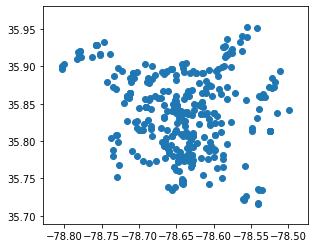

In [118]:
bp_gdf().plot()

In [119]:
bp_gdf().to_file('./DATA/building_permits_1month.geojson', driver = 'GeoJSON')

### GoRaleigh Infrastructure

#### REST to gdf function

In [120]:
def arcgis_rest_to_gdf(url, layer_id):
  url = f'{url}/{layer_id}/query'
  params = {
    'f': 'geojson',
    'where': '1=1',
    'outFields': '*',
    'outSR': 4326
  }
  r = requests.get(url, params = params)
  return gpd.read_file(BytesIO(r.content))

#### Stops

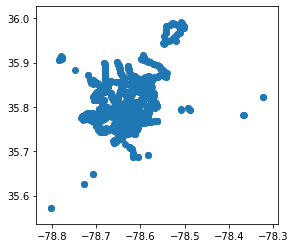

In [121]:
stops_gdf = arcgis_rest_to_gdf("https://services.arcgis.com/v400IkDOw1ad7Yad/ArcGIS/rest/services/GoRaleigh_Stops/FeatureServer", 0)
stops_gdf.plot()

In [123]:
stops_gdf.to_file('./DATA/goraleigh_stops.geojson', driver = 'GeoJSON')

#### Shelters

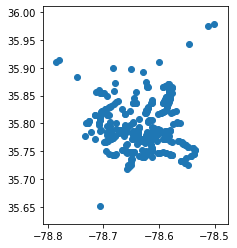

In [125]:
shelters_gdf = arcgis_rest_to_gdf("https://services.arcgis.com/v400IkDOw1ad7Yad/arcgis/rest/services/GoRaleigh_Shelters/FeatureServer", 0)
shelters_gdf.plot()

In [126]:
shelters_gdf.to_file('./DATA/goraleigh_shelters.geojson', driver = 'GeoJSON')